In [1]:
#configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing the data set form kaggle

In [2]:
#Api to fecth the dataset from kaggle
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

 75% 81.0M/107M [00:00<00:00, 152MB/s]
100% 107M/107M [00:00<00:00, 152MB/s] 


In [3]:
##extracting all the zipfile
from zipfile import ZipFile
dataset = '/content/brian-tumor-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [4]:
!ls  #to list all the directories

'Brain Tumor Data Set'	   kaggle.json	  metadata_rgb_only.csv
 brian-tumor-dataset.zip   metadata.csv   sample_data


Importing the dependencies

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
for dirname, _, filenames in os.walk('/content/Brain Tumor Data Set'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2339).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1293).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (461).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1026).JPG
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1530).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (698).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (68).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1445).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (418).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2370).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (141).jpg
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1891).jpg
/content/Brain Tumor Data Set/Brai

In [16]:
tumor_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
file_paths = []
labels = []
dict_list = [tumor_dir , healthy_dir]
for i , j in enumerate(dict_list):
  flist = os.listdir(j)
  for f in flist:
    fpath=os.path.join(j,f)
    file_paths.append(fpath)
    if i==0:
      labels.append('cancer')
    else:
      labels.append('healthy') 

In [17]:
Fseries = pd.Series(file_paths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
1  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
2  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
3  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
4  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


**Train test split**

In [20]:
train_images , test_images =train_test_split(tumor_df , test_size = 0.3 , random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [21]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


**Image data generator**

In [24]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                      )

Found 3680 validated image filenames belonging to 2 classes.


In [25]:
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

Found 1380 validated image filenames belonging to 2 classes.


In [26]:
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 920 validated image filenames belonging to 2 classes.


In [27]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


Model building

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [29]:
##defining the sequential model
model = Sequential()
##adding the convo-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))  ##max pooling layer
#adding flatten layer
model.add(Flatten())
#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))
#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 468512)            0         
                                                                 
 dense (Dense)               (None, 128)               59969664  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [30]:
#trainin the model
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 203s 2s/step - loss: 3.8179 - accuracy: 0.6812 - val_loss: 0.3879 - val_accuracy: 0.8446
Epoch 2/10
115/115 [==============================] - 192s 2s/step - loss: 0.3350 - accuracy: 0.8617 - val_loss: 0.1931 - val_accuracy: 0.9380
Epoch 3/10
115/115 [==============================] - 191s 2s/step - loss: 0.1960 - accuracy: 0.9266 - val_loss: 0.1610 - val_accuracy: 0.9424
Epoch 4/10
115/115 [==============================] - 192s 2s/step - loss: 0.1132 - accuracy: 0.9625 - val_loss: 0.1157 - val_accuracy: 0.9663
Epoch 5/10
115/115 [==============================] - 192s 2s/step - loss: 0.0750 - accuracy: 0.9758 - val_loss: 0.0915 - val_accuracy: 0.9696
Epoch 6/10
115/115 [==============================] - 198s 2s/step - loss: 0.0673 - accuracy: 0.9761 - val_loss: 0.0938 - val_accuracy: 0.9674
Epoch 7/10
115/115 [==============================] - 192s 2s/step - loss: 0.0727 - accuracy: 0.9747 - val_loss: 0.0951 - val_accuracy: 0.9663

Visualizing the accuracy of model

Text(0.5, 1.0, 'Training and Validation Accuracy')

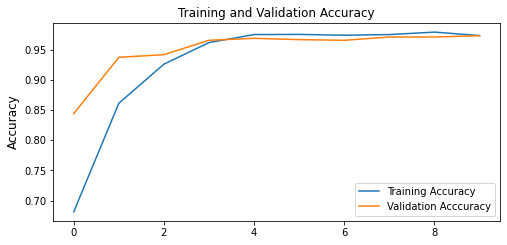

In [31]:
import matplotlib.pyplot as plt
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

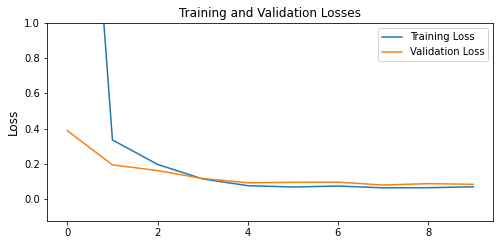

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [33]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 21s 462ms/step - loss: 0.0607 - accuracy: 0.9812


[0.06065041944384575, 0.9811594486236572]

In [34]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 [==============================] - 20s 443ms/step


In [36]:
from sklearn.metrics import accuracy_score
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.98      0.99      0.98       779
     healthy       0.98      0.98      0.98       601

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380

Accuracy of the Model: 98.1159420289855 %


<AxesSubplot:>

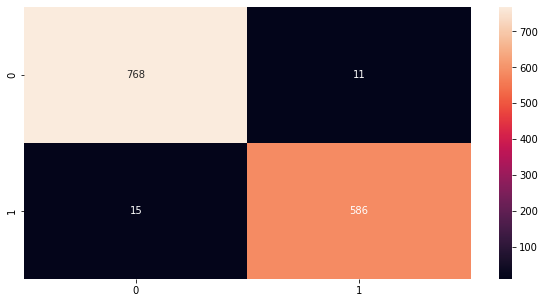

In [38]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')